# Importing Important Libraries

In [1]:
# Oil Spill Detection using CNN
# Import necessary libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


Batches per epoch = (Dataset size) / (batch size)

Dataset Configuration

In [3]:
# 1. DATASET CONFIGURATION

# Define dataset paths
DATASET_PATH = 'OIL SPILLS PRJ/dataset'  # Update this path
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 2  # Binary classification (oil spill vs no oil spill)
EPOCHS = 50

print(f"Dataset Path: {DATASET_PATH}")
print(f"Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")

Dataset Path: OIL SPILLS PRJ/dataset
Image Size: 224x224
Batch Size: 32
Number of Classes: 2


# Loading the Dataset

In [4]:

# 2. LOAD DATASET (Segmentation)

import tensorflow as tf
import os

# Define the base directory for your dataset
BASE_DATA_DIR = 'E:\\Oil Spills Prj\\dataset'

# Define image dimensions and batch size
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8


# 1. Loading the Training Dataset

print('================== LOADING TRAINING DATASET ==================')
TRAIN_IMG_PATH = os.path.join(BASE_DATA_DIR, 'train', 'images')
TRAIN_MASK_PATH = os.path.join(BASE_DATA_DIR, 'train', 'masks')

# Get sorted lists of image and mask filenames
train_image_filenames = sorted(os.listdir(TRAIN_IMG_PATH))
train_mask_filenames = sorted(os.listdir(TRAIN_MASK_PATH))

# Create a list of full paths for both images and masks
train_image_paths = [os.path.join(TRAIN_IMG_PATH, name) for name in train_image_filenames]
train_mask_paths = [os.path.join(TRAIN_MASK_PATH, name) for name in train_mask_filenames]


# 2. Loading the Validation Dataset

print('================= LOADING VALIDATION DATASET =================')
VAL_IMG_PATH = os.path.join(BASE_DATA_DIR, 'val', 'images')
VAL_MASK_PATH = os.path.join(BASE_DATA_DIR, 'val', 'masks')

val_image_filenames = sorted(os.listdir(VAL_IMG_PATH))
val_mask_filenames = sorted(os.listdir(VAL_MASK_PATH))

val_image_paths = [os.path.join(VAL_IMG_PATH, name) for name in val_image_filenames]
val_mask_paths = [os.path.join(VAL_MASK_PATH, name) for name in val_mask_filenames]

# 3. Loading the Test Dataset

print('=================== LOADING TEST DATASET =====================')
TEST_IMG_PATH = os.path.join(BASE_DATA_DIR, 'test', 'images')
TEST_MASK_PATH = os.path.join(BASE_DATA_DIR, 'test', 'masks')

test_image_filenames = sorted(os.listdir(TEST_IMG_PATH))
test_mask_filenames = sorted(os.listdir(TEST_MASK_PATH))

test_image_paths = [os.path.join(TEST_IMG_PATH, name) for name in test_image_filenames]
test_mask_paths = [os.path.join(TEST_MASK_PATH, name) for name in test_mask_filenames]


# 4. TensorFlow Data Pipeline Functions
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Assuming PNG masks
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask > 0, tf.float32)

    return image, mask

def create_dataset(image_paths, mask_paths, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_image_and_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


# 5. Creating the Final Datasets

train_dataset = create_dataset(train_image_paths, train_mask_paths, shuffle=True)
val_dataset = create_dataset(val_image_paths, val_mask_paths, shuffle=False)
test_dataset = create_dataset(test_image_paths, test_mask_paths, shuffle=False)

# Optional: Print the shapes of a batch to verify
for images, masks in train_dataset.take(1):
    print("\nTraining Batch Shapes:")
    print("Images shape:", images.shape)
    print("Masks shape:", masks.shape)

================== LOADING TRAINING DATASET ==================
================= LOADING VALIDATION DATASET =================
=================== LOADING TEST DATASET =====================

Training Batch Shapes:
Images shape: (32, 224, 224, 3)
Masks shape: (32, 224, 224, 1)


# VISUALIZING SAMPLE IMAGES


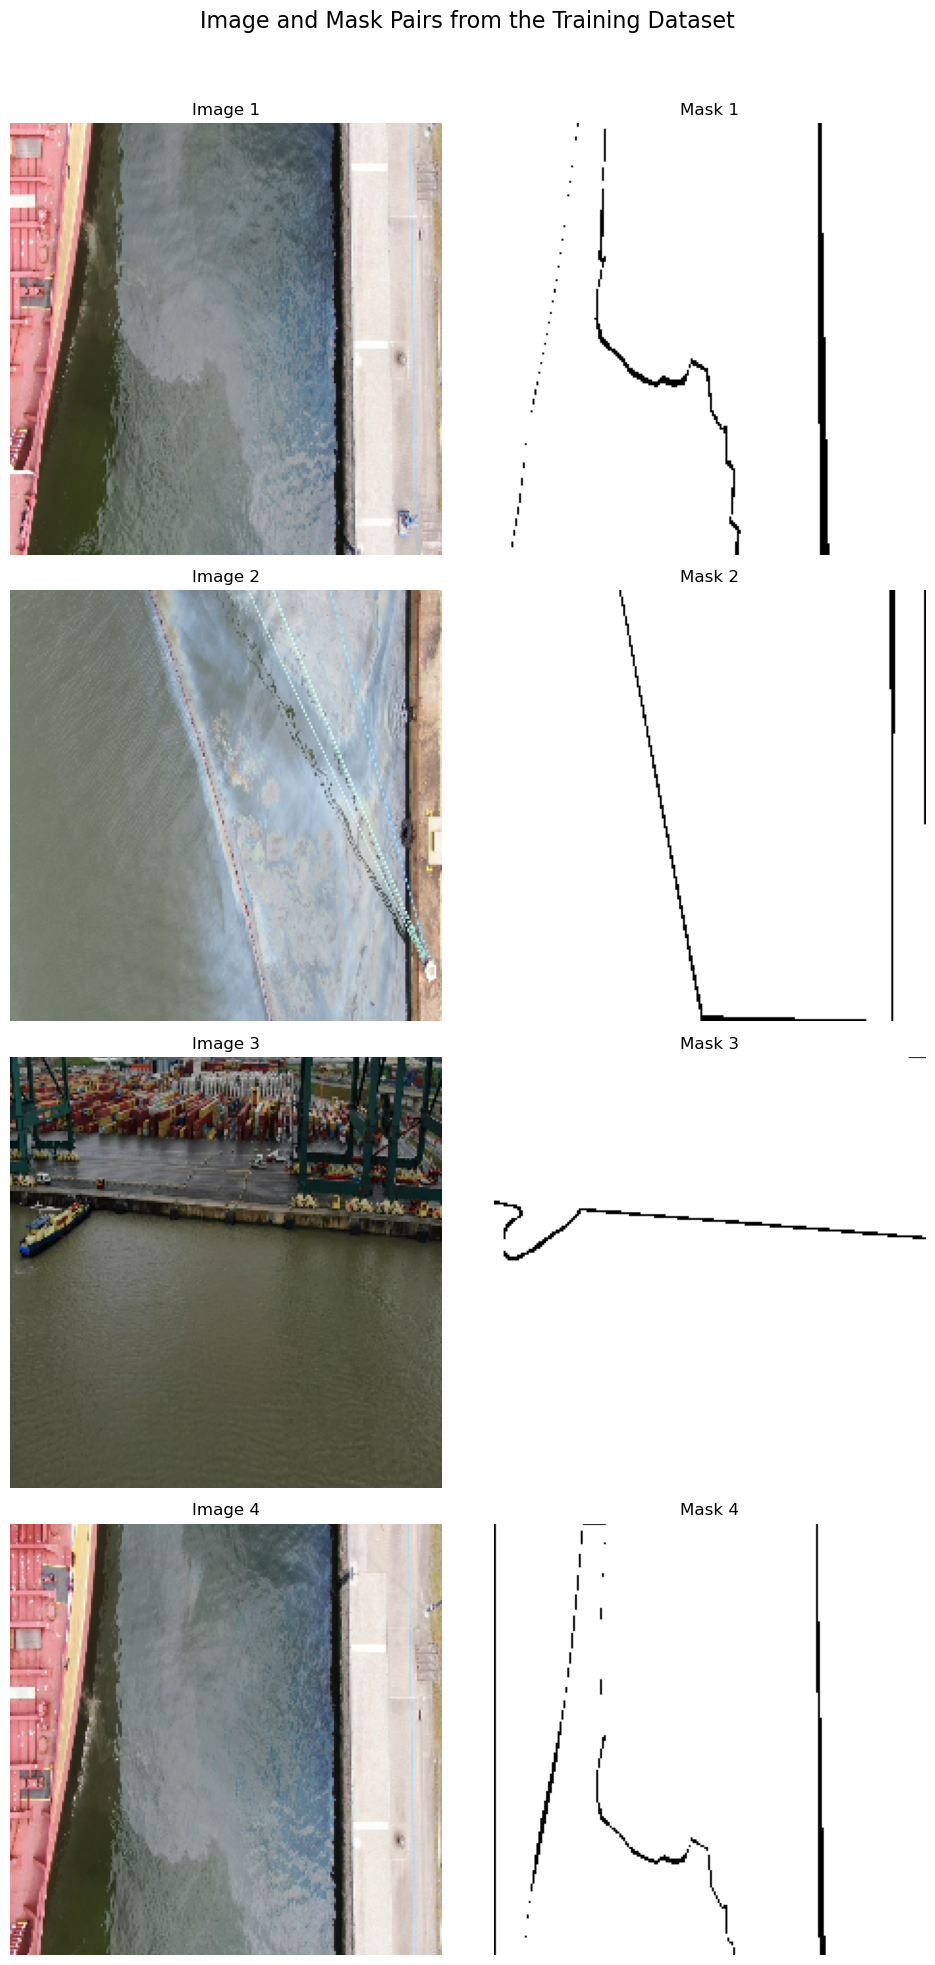

In [5]:

# 3. VISUALIZE SAMPLE IMAGES

import matplotlib.pyplot as plt
import numpy as np

# Take one batch from the training dataset
sample_images, sample_masks = next(iter(train_dataset))

# Display the first 4 pairs of images and masks
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
plt.suptitle('Image and Mask Pairs from the Training Dataset', fontsize=16)

for i in range(4):
    # Display the original image
    axes[i, 0].imshow(sample_images[i])
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')

    # Display the corresponding mask
    # We use .squeeze() to remove the single channel dimension (e.g., from (256, 256, 1) to (256, 256))
    axes[i, 1].imshow(np.squeeze(sample_masks[i]), cmap='gray')
    axes[i, 1].set_title(f'Mask {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# NORMALIZATION


In [ ]:
# 4. NORMALIZATION

# Function to load and preprocess a single image and its corresponding mask
def load_image_and_mask(image_path, mask_path):
    """Loads and preprocesses an image and its mask."""
    # Load and decode image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # <<<--- THIS IS THE IMAGE NORMALIZATION STEP

    # Load and decode mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)  # Masks are often grayscale (1 channel)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask > 0, tf.float32) # <<<--- THIS ENSURES THE MASK IS BINARY (0 or 1)

    return image, mask


# Data Augmentation

In [ ]:

# 5. DATA AUGMENTATION

import tensorflow as tf
import numpy as np

# A new function to apply augmentation
def augment_data(image, mask):
    # 1. Random Flip (Horizontal)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # 2. Random Rotation

    # tf.image.rot90 is graph-friendly, but only does 90-degree rotations.
    # For a more general rotation, we can use a custom function
    # a simple combination of other ops.
    # A cleaner solution is to rotate by a random multiple of 90 degrees.
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    # 3. Random Brightness (on image only)

    image = tf.image.random_brightness(image, max_delta=0.2)

    # 4. Final Clip

    # Clip the image to ensure it's in the [0, 1] range after brightness adjustments
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, mask

# Note: The rest of your code (`create_dataset` and the dataset creation calls)
# remains the same. The `tf.data` pipeline will handle the
# transformation correctly with this revised `augment_data` function.

In [ ]:
# 6. OPTIMIZE DATASET PERFORMANCE

AUTOTUNE = tf.data.AUTOTUNE

train_dataset_final = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset_final = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset_final = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("\n✓ Dataset optimization applied (caching and prefetching)")

In [ ]:
# 7. BUILD THE MODEL (U-Net Example)
'''
U-Net is a deep learning architecture, originally designed for biomedical image segmentation.
The key idea of U-Net is that it not only extracts features from images but also reconstructs them back to their original size to produce a mask.
'''

def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = layers.Input(input_size)
    # Encoder ->> This part extracts features from the image using convolutional layers and reduces the image size using max pooling.
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck ->> This is the middle layer of the network where deep features are captured.
    b1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    b1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(b1)

    # Decoder ->> This part reconstructs the image back to the original size. It combines features from the encoder using skip connections, which means information from earlier layers is carried forward to later layers.

    u1 = layers.UpSampling2D((2,2))(b1)
    concat1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat1)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D((2,2))(c3)
    concat2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(concat2)
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)  
    # Model outpu is a Binary mask

    model = models.Model(inputs, outputs)
    return model

# Instantiate the model
model = unet_model()

# 8. COMPILE THE MODEL - >> Adam optimizer to efficiently adjust weights during training.

# it helps computer to learn to draw the perfect outline ->> binary cross entropy loss function
# suppose you have a photo and you want to highlight something from it seperatly - >> binary segmentation


#LEARNING RATE ->> it define how quickly or slowly a model learns. A higher learning rate means the model will make larger updates to its weights during training, which can lead to faster convergence but also risks overshooting the optimal solution. A lower learning rate means smaller updates, which can lead to more precise convergence but may take longer to train.

# firest i used it for 1e-4 but it was slow so i increased it to 1e-2 

model.compile(optimizer=Adam(learning_rate=1e-2),
              loss='binary_crossentropy',  # or tf.keras.losses.DiceLoss()
              metrics=['accuracy'])

# 9. CALLBACKS

# Save the best model based on validation loss
checkpoint_cb = ModelCheckpoint('best_unet_model.h5', save_best_only=True, monitor='val_loss')
earlystop_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

# 10. TRAIN THE MODEL

# Epochs is Ml is simply one complete pass through the entire training dataset.
# epochs = 50 already defined in image parameters section

history = model.fit(
    train_dataset_final,
    epochs=EPOCHS,
    validation_data=val_dataset_final,
    callbacks=callbacks
)

# 11. EVALUATE AND INFER

# Evaluate on test data
results = model.evaluate(test_dataset_final)
print("Test Results:", results)

# Predict masks on new images
for test_images, test_masks in test_dataset_final.take(1):
    predictions = model.predict(test_images)

    # Visualize predictions
    for i in range(len(test_images)):
        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1)
        plt.imshow(test_images[i])
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(np.squeeze(test_masks[i]), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(np.squeeze(predictions[i]) > 0.5, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        plt.show()

In [ ]:
# Set input channels based on your data
INPUT_CHANNELS = 1  # Use 1 for SAR, 3 for RGB, or any number for multi-channel

def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS)):
    inputs = layers.Input(input_size)
    # Encoder layers...
    # (Rest of the model architecture remains unchanged)
    # — see previous code for full details
    return models.Model(inputs, outputs)

# When loading images for single-channel, adjust decode function:
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=INPUT_CHANNELS)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    # (mask code stays the same)
    return image, mask

# Use INPUT_CHANNELS in the rest of your pipeline!


In [ ]:
import tensorflow.keras.backend as K

# Dice Loss Function for Binary Segmentation
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Use in compile:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,  # Or combine with BCE for total_loss
    metrics=['accuracy']
)


In [ ]:
def total_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [ ]:
def iou_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

def dice_coef(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + 1e-7) / (K.sum(y_true) + K.sum(y_pred) + 1e-7)

def precision(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    tp = K.sum(y_true * y_pred)
    fp = K.sum((1-y_true) * y_pred)
    return tp / (tp + fp + 1e-7)

def recall(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    tp = K.sum(y_true * y_pred)
    fn = K.sum(y_true * (1-y_pred))
    return tp / (tp + fn + 1e-7)

# Add to model compile:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=total_loss,
    metrics=['accuracy', iou_metric, dice_coef, precision, recall]
)


In [ ]:
import inspect

print("---- SOURCE FOR unet_model() ----")
print(inspect.getsource(unet_model))


In [ ]:
from tensorflow.keras import layers, models

def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS)):
    inputs = layers.Input(input_size)
    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    b = layers.Conv2D(64, 3, activation='relu', padding='same')(b)

    # Decoder
    u1 = layers.UpSampling2D()(b)
    concat1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat1)
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D()(c3)
    concat2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(concat2)
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)
    return models.Model(inputs, outputs)


In [ ]:
def unet_model(input_size=(224, 224, 3)):   # 3 channels for RGB
    inputs = layers.Input(input_size)
    # --- Encoder ---
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # --- Bottleneck ---
    b1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    b1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(b1)

    # --- Decoder ---
    u1 = layers.UpSampling2D((2, 2))(b1)
    concat1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat1)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D((2, 2))(c3)
    concat2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(concat2)
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)  # binary mask
    model = models.Model(inputs, outputs)
    return model


In [ ]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
model = unet_model()

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_dataset_final,
    epochs=EPOCHS,
    validation_data=val_dataset_final,
    callbacks=callbacks
)
